In [1]:
import cv2
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import draw

In [2]:
# approximation
UPPER_BOUNDS_CAM1 = [[110,150], [95,175],
                     [90,200], [85,225], [82,250], [80,275], 
                     [78,300], [75,325], [73,350], [73,375],
                     [72,400], [71,425], [71,450], [71,475],
                     [70,500], [70,525], [70,550], [70,575],
                     [70,600], [70,625], [70,650], [70,675],
                     [70,700], [70,725], [70,750], [70,775],
                     [75,800], [73,825], [75,850], [76,875],
                     [77,900], [78,925], [78,950], [81,975],
                     [82,1000], [88,1025], [94,1050], 
                     [100,1075], [100,1100], [120,1125]]

UPPER_BOUNDS_CAM1 = np.array(UPPER_BOUNDS_CAM1)

DATA_POINTS_INDICES = [2,6,10,14,18,22,26,30,34]
DATA_POINTS = UPPER_BOUNDS_CAM1[DATA_POINTS_INDICES]

In [3]:
# filename is an image file
def preprocess_image(bgr_image):
    #bgr_image       = cv2.imread(filename)
    rgb_image       = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    gray_image      = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY)
    _, binary_image = cv2.threshold(gray_image, 210, 255, cv2.THRESH_BINARY)
    binary_image    = binary_image/255
    
    return binary_image, rgb_image

In [4]:
# point is a starting coordinate --> [y,x]
# this function is used in inversed_hieghts() function
def count_pixel(binary_image, point):
    y = point[0]
    x = point[1]
    no_of_pixels = 0
    
    while binary_image[y,x] == 1:
        y += 1
        no_of_pixels += 1
    
    return no_of_pixels

In [5]:
# count_pixel() counts the pixels using top-down approach
# 1 points at a time
# inversed_heights() repeats count_pixel() many times
def inversed_heights(binary_image, starting_points):
    heights = []
    for point in starting_points:
        height = count_pixel(binary_image, point)
        # If the height is not too low AND if previous point exists
        if height>260 and len(heights)>0:
            height = heights[-1]
        heights.append(height)
    return np.array(heights)

In [6]:
# determine the actual boundary location
def find_boundary_coords(inversed_height_points, upper_bounds):
    y_locs = upper_bounds[:,0] + inversed_height_points
    x_locs = upper_bounds[:,1]
    
    y_locs = y_locs[:,np.newaxis]
    x_locs = x_locs[:,np.newaxis]
    
    coords = np.hstack((y_locs, x_locs))
    
    return coords

In [7]:
# calculates the actual water height
# (container_height - inversed_height)
def actual_height(inversed_height):
    return 302-inversed_height

In [8]:
def pixel_to_mm(value):
    return value*0.828

In [9]:
def line_indices(boundary_coords):
    rrs = []
    ccs = []
    for i in range(len(boundary_coords)-1):
        y0 = boundary_coords[i][0]
        x0 = boundary_coords[i][1]
        y1 = boundary_coords[i+1][0]
        x1 = boundary_coords[i+1][1]
        
        rr, cc, _ = draw.line_aa(y0, x0, y1, x1)
        rrs.append(rr)
        ccs.append(cc)
    
    return rrs, ccs

In [10]:
def draw_lines(rgb_image, rrs, ccs):
    for rr, cc in zip(rrs, ccs):
        rgb_image[rr,cc,0] = 0
        rgb_image[rr,cc,1] = 0
        rgb_image[rr,cc,2] = 255
        
        rgb_image[rr+1,cc+1,0] = 0
        rgb_image[rr+1,cc+1,1] = 0
        rgb_image[rr+1,cc+1,2] = 255
    
    return rgb_image

In [11]:
def load_video(filename, no_of_frames):
    video = imageio.get_reader(filename, 'ffmpeg')
    binary_frames = []
    rgb_frames = []
    for i in tqdm(range(no_of_frames)):
        image = np.array(video.get_data(i))
        binary_image, rgb_image = preprocess_image(image)
        
        binary_frames.append(binary_image)
        rgb_frames.append(rgb_image)
        
    binary_frames = np.array(binary_frames)
    rgb_frames = np.array(rgb_frames)
    
    return binary_frames, rgb_frames

In [12]:
def draw_line_on_frames(binary_frames, rgb_frames):
    
    wave_data = []
    frames_with_boundary = []
    
    for binary_image, rgb_image in tqdm(zip(binary_frames, rgb_frames)):
        
        heights = inversed_heights(binary_image, UPPER_BOUNDS_CAM1)
        
        wave_data.append(take_data(heights))
        
        boundary_coords = find_boundary_coords(heights, UPPER_BOUNDS_CAM1)
        rrs, ccs = line_indices(boundary_coords)
        
        rgb_image_with_line = draw_lines(rgb_image, rrs, ccs)
        rgb_image_with_line = crop_frame(rgb_image_with_line)
        
        frames_with_boundary.append(rgb_image_with_line)
    
    return np.array(frames_with_boundary), np.array(wave_data)

In [13]:
def take_data(heights):
    heights_to_save = heights[DATA_POINTS_INDICES]
    heights_to_save = actual_height(heights_to_save)
    heights_to_save = pixel_to_mm(heights_to_save)
    return heights_to_save

In [14]:
def crop_frame(image):
    return image[:450, :, :]

# Main program goes below

In [15]:
binary_frames, rgb_frames = load_video('CCFL002_1_2000_500_up_cam2_a.avi', 600)

100%|██████████| 600/600 [00:11<00:00, 53.82it/s]


In [16]:
frames_with_boundary, wave_data = draw_line_on_frames(binary_frames, rgb_frames)

600it [00:08, 70.85it/s]


In [17]:
frames_with_boundary.shape

(600, 450, 1280, 3)

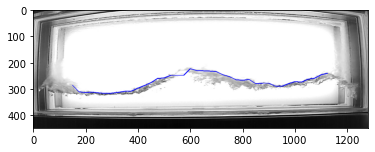

In [18]:
plt.imshow(frames_with_boundary[77])

In [19]:
column_names = ['Point 0', 'Point 1', 'Point 2', 'Point 3', 'Point 4', 
                'Point 5', 'Point 6', 'Point 7', 'Point 8']
df = pd.DataFrame(wave_data, columns=column_names)

In [20]:
df.to_csv('Data.csv')

In [21]:
size = 1280, 450
duration = 10
fps = 60
out = cv2.VideoWriter('output3.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, size)

In [22]:
for i in tqdm(range(fps*duration)):
    out.write(frames_with_boundary[i])
out.release()

100%|██████████| 600/600 [00:03<00:00, 161.67it/s]


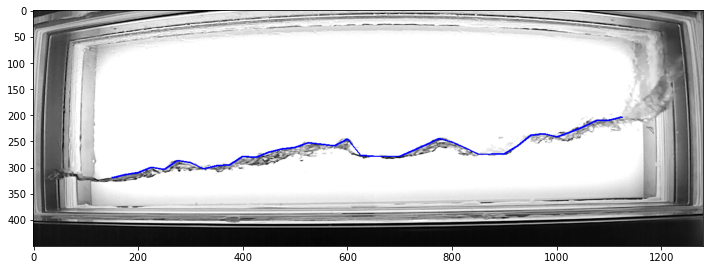

In [23]:
plt.figure(figsize=(12,12))
plt.imshow(frames_with_boundary[38])